In [1]:
local installed;
try
    installed;
catch ex
    using Pkg
    Pkg.add("DifferentialEquations");
    Pkg.add("Optim");
    Pkg.add("Plots");
    Pkg.add("QuadGK"); 
    installed = true;
end

    Updating registry at `C:\Users\Vasil\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\Vasil\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Vasil\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Vasil\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Vasil\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Vasil\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Vasil\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Vasil\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Vasil\.julia\environments\v1.6\Manifest.toml`


true

In [2]:
using Plots;
using DifferentialEquations;
using QuadGK;
using Optim;


(process:13468): GLib-GIO-WARNING **: 20:39:55.530: Unexpectedly, UWP app `BluskySoftwareInc.AudiotonicPro_2.0.4.0_x86__61yk12x6sxn40' (AUMId `BluskySoftwareInc.AudiotonicPro_61yk12x6sxn40!audacity') supports 49 extensions but has no verbs


# Експериментиране с shooting methods/b.c. fitting

Тук ще тестваме идеята за фитинг на граничните условия с цел да преобразуваме гранична задача (BVP) в начална такава (IVP).

За начало ще се опитаме да решаваме с метод за IVP, задачата:
$$
    u'' = -1 \\
    u(0) = 0 \\ 
    u(1) = 0 \\
$$

Точното решение се дава с:
$$
    u(x) = \frac{1}{2} (1-x) x
$$

In [3]:
function exact_sol(x)
    -0.5 * (x-1) * x
end

exact_sol (generic function with 1 method)

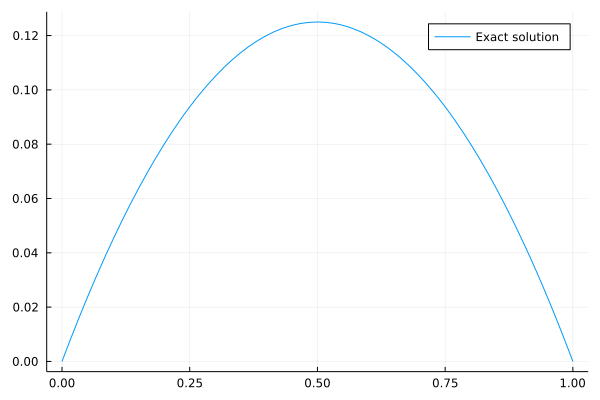

In [4]:
plot(exact_sol, 0, 1, label = "Exact solution")

Горната задача ще се опитаме да преобразуваме в:
$$
 u'' = -1 \\
 u(0) = \alpha \\  
 u'(0) = \beta  \\
 x_0 = 0 \\ 
 x_{max} = 1
$$

Да отбележим, решението на дадената задача на Коши при конкретен избор на параметри $\alpha, \beta$ с $u_{\alpha, \beta}$.
Точното решение пък да отбележим с $u^*$.

Търсим:
$$
(\alpha^*, \beta^*) = argmin_{\alpha, \beta}  || u_{\alpha, \beta} - u^* ||
$$ 

Изборът на норма също следва да бъде въпрос, който не следва да пренеберегваме за по-сложни задачи. За конкретния случай ще използваме $ || \cdot ||_{2} $

In [5]:
function rhs(u, p, t) 
    return [u[2],-1]
end;

In [6]:
function shooting_solution(initial_conds)
    u0 = initial_conds
    tspan = [0,1]
    prob = ODEProblem(rhs, u0, tspan)
    sol = solve(prob, dense=true, abstol=1e-12)
    return sol
end;

In [7]:
function calculate_resid(initial_conds)
    sol = shooting_solution(initial_conds)
    function integrand(x)
        (sol(x)[1] - exact_sol(x))^2
    end
    return quadgk(integrand, 0, 1, rtol=1e-12)[1]
end;

In [8]:
function calculate_resid_bc_only(initial_conds)
    # uses only information known from the BVP, without the exact solution being available
    sol = shooting_solution(initial_conds)
    return sol(0)[1]^2 + sol(1)[1]^2
end;

In [9]:
res = optimize(calculate_resid_bc_only, [0.0, 0.0], f_tol=1e-12)

 * Status: success

 * Candidate solution
    Final objective value:     1.399527e-08

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    26
    f(x) calls:    56


In [10]:
(alpha, beta) = Optim.minimizer(res)

2-element Vector{Float64}:
 9.264565082960363e-5
 0.499833787711623

In [11]:
ivp_sol(x) = shooting_solution([alpha,beta])(x)[1]

ivp_sol (generic function with 1 method)

След като решихме оптимизационната задача за $\alpha, \beta$ можем да изчертаем двете графики и да забележим, че те са на практика неразличими

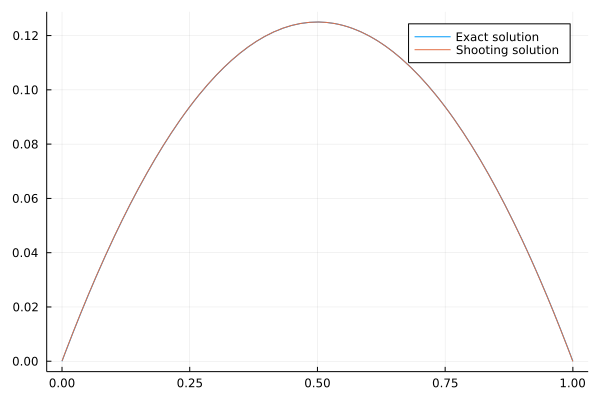

In [12]:
plot(exact_sol, 0, 1, label = "Exact solution")
plot!(ivp_sol, label = "Shooting solution")